In [1]:
import sys 
sys.path.append('..')
from utils import *
from kernels import *
from distributions import *
from kernelGAN import *
import torch, matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

device = torch.device('cpu')
%matplotlib inline
plt.rcParams.update({'font.size': 20})
%load_ext autoreload
%autoreload 2

### Initializing Generated Points with Zero Mean

In [5]:
# distribution params
n_true, n_gen, d = 1, 20, 2
n_mixture = 20
device = torch.device('cpu')
# initializing points
X_true = torch.tensor([[0, 0]], dtype=torch.float32)
p_true = torch.ones(n_true).softmax(-1)
# gen_distr = get_distr('ring', dim=d, n_mixture=n_mixture, std=0, radius=1, device=device)
# X_gen_init, _ = gen_distr.sample_n(n_gen)
# X_gen_init = X_gen_init@torch.diag(torch.Tensor([0.5,0.5]))
m = torch.distributions.MultivariateNormal(torch.zeros(2), torch.diag(torch.Tensor([.1,.2])))
X_gen_init = m.sample((n_gen,))
X_gen_init -= torch.mean(X_gen_init, axis=0)
_, eigvec = torch.linalg.eigh(X_gen_init.T@X_gen_init)
X_gen_init = X_gen_init@eigvec
p_gen = torch.ones(n_gen).softmax(-1)

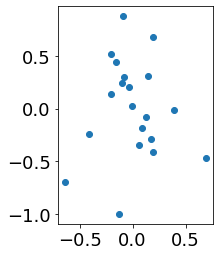

mean: tensor([1.3411e-08, 0.0000e+00])


In [6]:
plt.scatter(X_gen_init[:,0],X_gen_init[:,1], )
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()
print(f'mean: {X_gen_init.mean(axis=0)}')

### Training Actual Kernel GAN

In [7]:
# initializing discriminator kernel
width_params=[[1,2],[1,10]]
# varying across training params
T = 2500
lr_combos = [(1e-2,1e-2)] #[(1e-1,1e-1), (1e-2,1e-2)] #(lr_d,lr_g)
lams = [1, 1e-1, 1e-2]
log_interval=10

In [63]:
W_dist = np.zeros((len(lr_combos), len(lams), len(width_params), T//log_interval))
X_hist = np.zeros((len(lr_combos), len(lams), len(width_params), T, n_gen, d))
for k, width_param in enumerate(width_params):
    # init kernel
    DK = Kernel('gaussian_ms', width_param=width_param)
    for i, (lr_d,lr_g) in enumerate(lr_combos):
        for j, lam in enumerate(lams):
            # init generator + discriminator
            G = PointGenerator(X_gen_init, p_gen)
            D = KernelDiscriminator(DK,d, lam, lr_d)
            # find generated trajectories
            model = KernelGAN(G, D, device)
            model.train(X_true, p_true, lr_d, lr_g, T, lam)
            # calculate w2 distances
            curr_w2 = wasserstein2(model.G.X_gen.detach().cpu(), X_true.detach().cpu(), log_interval)
            W_dist[i, j, k, :] = curr_w2
            X_hist[i, j, k, :, : , :] = model.G.X_gen.detach().cpu()

100%|██████████| 250/250 [00:00<00:00, 1078.93it/s]


In [64]:
#(optional) save X_hist
np.save('../data/var_ODE_multiscale_sim2', X_hist)

In [4]:
X_hist = np.load('../data/var_ODE_sim2.npy')
X_gen_init = torch.tensor(X_hist[0,0,0,0,:,:])

### ODE Approximations

In [41]:
rho_hist = np.zeros((len(lr_combos), len(lams), len(width_params), T, d))

for k, width_param in enumerate(tqdm(width_params)):
    sig_effective = np.power(len(width_param), 1/4)*np.min(width_param)
    gam = 1/(sig_effective**2)
    for i, (lr_d,lr_g) in enumerate(lr_combos):
        for j, lam in enumerate(lams):
            # first get eigenvalues of init cov. matrix
            Cov = (X_gen_init.T@X_gen_init)/n_gen
            rhos,_ = torch.linalg.eigh(Cov)
            rho1, rho2 = rhos[0],rhos[1]
            c1,c2 = 0,0
            for it in range(T):              
                # Quadratic model
                c1 = (1-lam*lr_d)*c1 + 0.5*(lr_d*gam**2)*(3*rho1 + rho2)
                c2 = (1-lam*lr_d)*c2 + 0.5*(lr_d*gam**2)*(rho1 + 3*rho2)
                rho1 = rho1*(1-lr_g*p_gen[0]*c1)**2
                rho2 = rho2*(1-lr_g*p_gen[0]*c2)**2
                rho_hist[i,j,k,it,0] = rho1
                rho_hist[i,j,k,it,1] = rho2

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


## Plotting

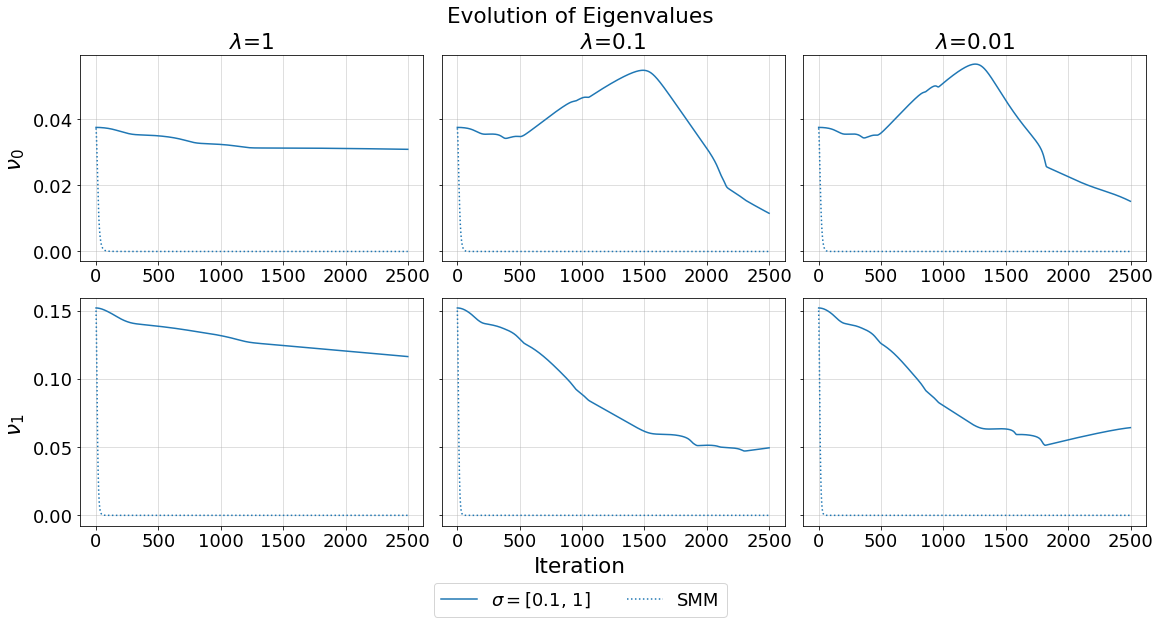

In [42]:
lr_index=0
# rho_index = 1
plt.rcParams.update({'font.size': 18})
# fig, ax = plt.subplots(2,3,figsize=(16,8), sharey=True)
fig = plt.figure(figsize=(16,8), constrained_layout=True)
subfigs = fig.subfigures(nrows=2, ncols=1)
# ymax = np.max(rho_hist)+0.01
for rho_index, subfig in enumerate(subfigs):
    # subfig.suptitle(f'Evolution of $\\nu_{int(rho_index)}$')
    subfig.supylabel(f'$\\nu_{int(rho_index)}$')
    # create 1x3 subplots per subfig
    ax = subfig.subplots(nrows=1, ncols=3, sharey=True)
    for j, lam in enumerate(lams):
        curr_ax =  ax[j]
        if rho_index==0:
            curr_ax.set_title(f'$\lambda$={lam}')
        # curr_ax.set_ylim(0,ymax)
        curr_ax.grid(alpha=0.5)
        for k, width_param in enumerate(width_params):
            curr_X_hist = X_hist[lr_index,j, k,:,:,:]
            V_hist = [X.T@X/n_gen for X in curr_X_hist]
            tv = [np.trace(X.T@X)/n_gen for X in curr_X_hist]
            rho1s = [np.linalg.eigh(Cov)[0][0] for Cov in V_hist] 
            rho2s = [np.linalg.eigh(Cov)[0][1] for Cov in V_hist] 
            rhos_select = rho1s if rho_index==0 else rho2s
            curr_ax.plot(list(range(0,T)), rhos_select, c=f'C{k}', label=f'$\sigma=${width_param}')
            curr_ax.plot(list(range(0,T)), rho_hist[lr_index,j, k,:,rho_index], c=f'C{k}', label=f'SMM', ls='dotted')
            
# fig.legend(labels=, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# fig.tight_layout(rect=[0.03, 0.03, 1, 0.90])
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(labels=labels, bbox_to_anchor=(0.5, -0.08), loc='lower center', ncol=6)
# fig.supylabel('Eigenvalue Magnitude')
fig.supxlabel('Iteration')
fig.suptitle('Evolution of Eigenvalues')

# fig.suptitle(f'Evolution of $\\nu_{int(1-rho_index)}$ ($\eta_d={lr_combos[lr_index][0]:.1e},\eta_g={lr_combos[lr_index][1]:.1e}$)')
# plt.savefig(f"../data/twopoint_lr{lr_index}_ODEoverlay.png", format='png', bbox_inches='tight')
plt.show()

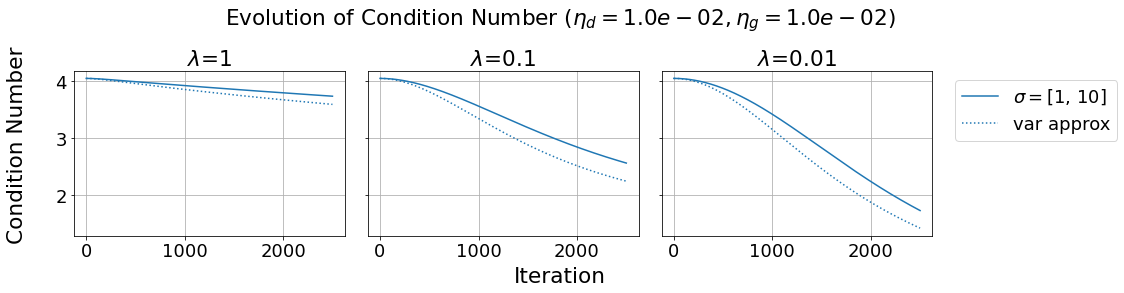

In [10]:
lr_index=0
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,3,figsize=(16,4), sharey=True)
for j, lam in enumerate(lams):
    # curr_ax = ax[j//2,j%2]
    curr_ax =  ax[j]
    curr_ax.set_title(f'$\lambda$={lam}')
    curr_ax.grid()
    for k, width_param in enumerate(width_params):
        curr_X_hist = X_hist[lr_index,j, k,:,:,:]
        V_hist = [X.T@X/n_gen for X in curr_X_hist]
        # tv = [np.trace(X.T@X)/n_gen for X in curr_X_hist]
        rho1_hist = np.array([np.linalg.eigh(Cov)[0][0] for Cov in V_hist])
        rho2_hist = np.array([np.linalg.eigh(Cov)[0][1] for Cov in V_hist]) 
        curr_ax.plot(list(range(0,T)), rho2_hist/rho1_hist, c=f'C{k}', label=f'$\sigma=${width_param}')
        rho1_pred = np.min(rho_hist[lr_index,j, k,:,:], axis=1)
        rho2_pred = np.max(rho_hist[lr_index,j, k,:,:], axis=1)
        curr_ax.plot(list(range(0,T)), rho2_pred/rho1_pred, c=f'C{k}', label=f'var approx', ls='dotted')
        # curr_ax.semilogy(list(range(0,T)), Xhistquad[lr_index,j, k,:]**2, c=f'C{k}', label=f'quadratic', ls='dotted')
        # curr_ax.semilogy(list(range(0,T)), Xhistavg[lr_index,j, k,:]**2, c=f'C{k}', label=f'avg', ls='dashed')
        # curr_ax.set_ylim((10**-14,10**3))
ax[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.tight_layout(rect=[0.03, 0.03, 1, 0.90])
fig.supylabel('Condition Number')
fig.supxlabel('Iteration')
fig.suptitle(f'Evolution of Condition Number ($\eta_d={lr_combos[lr_index][0]:.1e},\eta_g={lr_combos[lr_index][1]:.1e}$)')
# plt.savefig(f"../data/twopoint_lr{lr_index}_ODEoverlay.png", format='png', bbox_inches='tight')
plt.show()

### Visualize evolution of covariance:

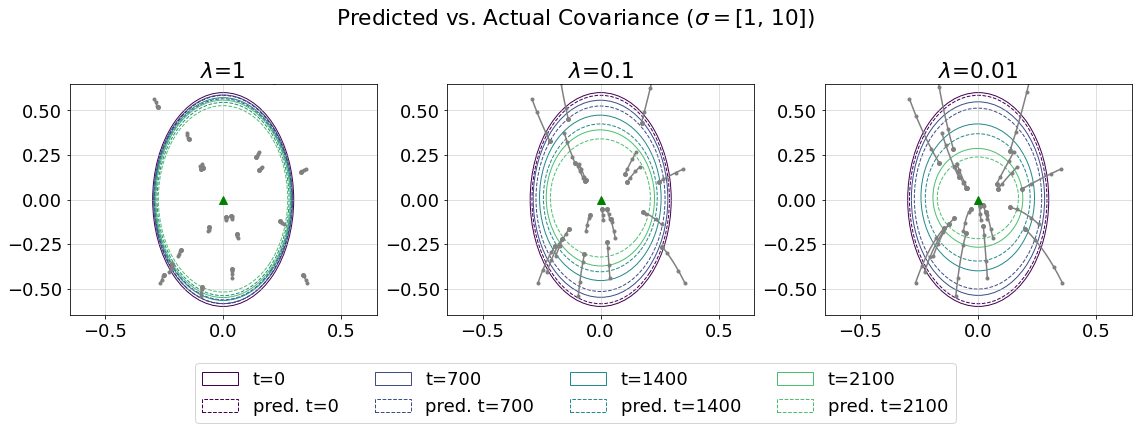

In [70]:
import matplotlib
lr_index=0
rho_index = 1
lim = 0.65
k = 4
width_param = width_params[k]
cmap = matplotlib.cm.get_cmap('viridis')
cmap_max = 0.85
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,3,figsize=(16,5), tight_layout=True)
for j, lam in enumerate(lams):
    curr_ax =  ax[j]
    curr_ax.set_title(f'$\lambda$={lam}')
    curr_ax.grid(alpha=0.5)
    # for k, width_param in enumerate(width_params):
    curr_X_hist = X_hist[lr_index,j, k,:,:,:]
    for t in range(0,T,700):
        # curr_ax.scatter(curr_X_hist[t,:,0], curr_X_hist[t,:,1])
        confidence_ellipse(curr_X_hist[t,:,0], curr_X_hist[t,:,1], curr_ax, n_std=1.5, edgecolor=cmap(cmap_max *t/T), 
                           label=f't={t}')
        _, eigvec = np.linalg.eigh((X_gen_init.T@X_gen_init)/n_gen)
        Cov_predicted = eigvec@np.diag(rho_hist[lr_index,j, k,t,:])@eigvec.T
        confidence_ellipse(curr_X_hist[t,:,0], curr_X_hist[t,:,1], curr_ax, cov=Cov_predicted, n_std=1.5, 
                           edgecolor=cmap(cmap_max *t/T), ls='dashed', label=f'pred. t={t}')
        curr_ax.set_xlim(-lim,lim); curr_ax.set_ylim(-lim,lim)
    for gen_idx in range(n_gen):
        curr_ax.plot(curr_X_hist[:,gen_idx,0],curr_X_hist[:,gen_idx,1], ls='-', c='gray', marker='o', ms=3, markevery=1000)
        curr_ax.plot(curr_X_hist[-1,gen_idx,0],curr_X_hist[-1,gen_idx,1], c='gray', marker='o', ms=4, linewidth=10)
    curr_ax.plot(0,0, c='g', marker='^', ms=8, linewidth=10)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4)
# fig.suptitle(f'$\eta_d=\eta_g=${lr_combos[0][0]:.1e}')
fig.suptitle(f'Predicted vs. Actual Covariance ($\sigma=${width_params[k]})')
plt.show()

## Combined Plot

In [10]:
X_hist = np.load('../data/var_ODE_sim2.npy')
X_hist_multiscale = np.load('../data/var_ODE_multiscale_sim2.npy')
X_hist = np.concatenate((X_hist, X_hist_multiscale), axis=2)
X_gen_init = torch.tensor(X_hist[0,0,0,0,:,:])
width_params = [[1],[2],[5],[1,2],[1,10]]

In [11]:
rho_hist = np.zeros((len(lr_combos), len(lams), len(width_params), T, d))

for k, width_param in enumerate(tqdm(width_params)):
    sig_effective = np.power(len(width_param), 1/4)*np.min(width_param)
    gam = 1/(sig_effective**2)
    gam2 = np.sum([1/((sig**4)*len(width_param)) for sig in width_param])
    print(gam2)
    for i, (lr_d,lr_g) in enumerate(lr_combos):
        for j, lam in enumerate(lams):
            # first get eigenvalues of init cov. matrix
            Cov = (X_gen_init.T@X_gen_init)/n_gen
            rhos,_ = torch.linalg.eigh(Cov)
            rho1, rho2 = rhos[0],rhos[1]
            c1,c2 = 0,0
            for it in range(T):              
                # Quadratic model
                # c1 = (1-lam*lr_d)*c1 + 0.5*(lr_d*gam**2)*(3*rho1 + rho2)
                # c2 = (1-lam*lr_d)*c2 + 0.5*(lr_d*gam**2)*(rho1 + 3*rho2)
                c1 = (1-lam*lr_d)*c1 + 0.5*(lr_d*gam2)*(3*rho1 + rho2)
                c2 = (1-lam*lr_d)*c2 + 0.5*(lr_d*gam2)*(rho1 + 3*rho2)
                rho1 = rho1*(1-lr_g*p_gen[0]*c1)**2
                rho2 = rho2*(1-lr_g*p_gen[0]*c2)**2
                rho_hist[i,j,k,it,0] = rho1
                rho_hist[i,j,k,it,1] = rho2

  0%|          | 0/5 [00:00<?, ?it/s]

1.0


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

0.0625


 40%|████      | 2/5 [00:01<00:02,  1.33it/s]

0.0016


 60%|██████    | 3/5 [00:02<00:01,  1.31it/s]

0.53125


 80%|████████  | 4/5 [00:03<00:00,  1.33it/s]

0.50005


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


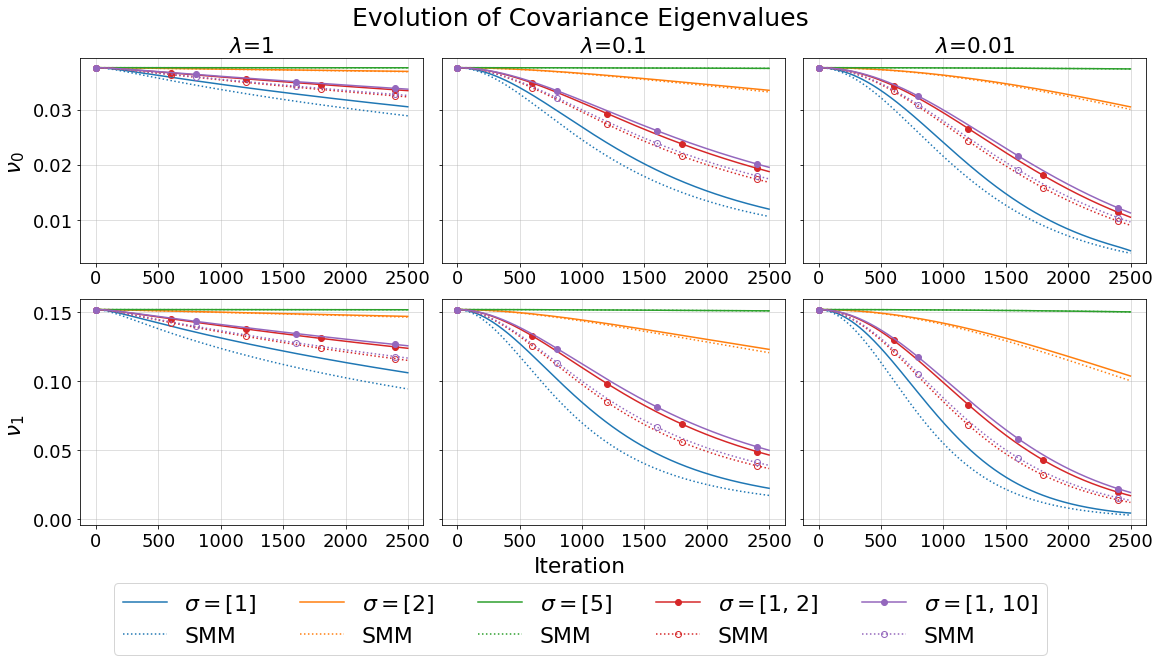

In [17]:
lr_index=0
# rho_index = 1
plt.rcParams.update({'font.size': 18})
# fig, ax = plt.subplots(2,3,figsize=(16,8), sharey=True)
fig = plt.figure(figsize=(16,8), constrained_layout=True)
subfigs = fig.subfigures(nrows=2, ncols=1)
# ymax = np.max(rho_hist)+0.01
for rho_index, subfig in enumerate(subfigs):
    # subfig.suptitle(f'Evolution of $\\nu_{int(rho_index)}$')
    subfig.supylabel(f'$\\nu_{int(rho_index)}$')
    # create 1x3 subplots per subfig
    ax = subfig.subplots(nrows=1, ncols=3, sharey=True)
    for j, lam in enumerate(lams):
        curr_ax =  ax[j]
        if rho_index==0:
            curr_ax.set_title(f'$\lambda$={lam}')
        # curr_ax.set_ylim(0,ymax)
        curr_ax.grid(alpha=0.5)
        for k, width_param in enumerate(width_params):
            curr_X_hist = X_hist[lr_index,j, k,:,:,:]
            V_hist = [X.T@X/n_gen for X in curr_X_hist]
            tv = [np.trace(X.T@X)/n_gen for X in curr_X_hist]
            rho1s = [np.linalg.eigh(Cov)[0][0] for Cov in V_hist] 
            rho2s = [np.linalg.eigh(Cov)[0][1] for Cov in V_hist] 
            rhos_select = rho1s if rho_index==0 else rho2s
            if len(width_param)>1:
                curr_ax.plot(list(range(0,T)), rhos_select, c=f'C{k}', label=f'$\sigma=${width_param}',
                              markevery=200*k, marker='o')
                curr_ax.plot(list(range(0,T)), rho_hist[lr_index,j, k,:,rho_index], c=f'C{k}', label=f'SMM', 
                             ls='dotted',  markevery=200*k, marker='o', fillstyle='none')
            else:
                curr_ax.plot(list(range(0,T)), rhos_select, c=f'C{k}', label=f'$\sigma=${width_param}')
                curr_ax.plot(list(range(0,T)), rho_hist[lr_index,j, k,:,rho_index], c=f'C{k}', label=f'SMM', ls='dotted')
            
# fig.legend(labels=, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# fig.tight_layout(rect=[0.03, 0.03, 1, 0.90])
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(labels=labels, bbox_to_anchor=(0.5, -0.15), loc='lower center', ncol=5, fontsize=22)
# fig.supylabel('Eigenvalue Magnitude')
fig.supxlabel('Iteration')
fig.suptitle('Evolution of Covariance Eigenvalues',fontsize=25)

# plt.savefig(f"../data/twopoint_lr{lr_index}_ODEoverlay.png", format='png', bbox_inches='tight')
plt.show()